In [6]:
import numpy as np
import pandas as pd
from pandas import concat
import talos
import matplotlib.pyplot as plt
from functools import reduce
import datetime as dt
from datetime import datetime
from math import floor, sqrt
import seaborn as sns

#tensorflow &keras
import tensorflow as tf
from keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, concatenate, Flatten, Input, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers, initializers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasRegressor
from keras.activations import *

#sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import preprocessing, metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

DNN Hyp search

In [13]:
df = pd.read_csv('/home/ciaran/Downloads/results_poisson.csv')

input_df = df.iloc[::2, :13]
output_df = df.iloc[1::2, :]
output_df.columns = [f'output_{i+1}' for i in range(len(output_df.columns))]

dat = pd.concat([input_df.reset_index(drop=True), output_df.reset_index(drop=True)], axis=1)
X_train=dat.iloc[:80,:13]
Y_train=dat.iloc[:80,13:]

X_test=dat.iloc[80:90,:13]
Y_test=dat.iloc[80:90,13:]


rnn_train_1 = X_train.iloc[:,0:1]
rnn_train_2 = X_train.iloc[:,1:2]
rnn_train_3 = X_train.iloc[:,2:3]
rnn_train_4 = X_train.iloc[:,3:13]
rnn_Y       = Y_train

rnn_test_1 = X_test.iloc[:,0:1]
rnn_test_2 = X_test.iloc[:,1:2]
rnn_test_3 = X_test.iloc[:,2:3]
rnn_test_4 = X_test.iloc[:,3:13]
rnn_test_Y = Y_test

X_scaler1 = preprocessing.MinMaxScaler()
X_scaler2 = preprocessing.MinMaxScaler()
X_scaler3 = preprocessing.MinMaxScaler()
X_scaler4 = preprocessing.MinMaxScaler()

rnn_scaled_train_1 = X_scaler1.fit_transform(rnn_train_1)
rnn_scaled_train_2 = X_scaler2.fit_transform(rnn_train_2)
rnn_scaled_train_3 = X_scaler3.fit_transform(rnn_train_3)
rnn_scaled_train_4 = X_scaler4.fit_transform(rnn_train_4)

rnn_scaled_test_1 = X_scaler1.transform(rnn_test_1)
rnn_scaled_test_2 = X_scaler2.transform(rnn_test_2)
rnn_scaled_test_3 = X_scaler3.transform(rnn_test_3)
rnn_scaled_test_4 = X_scaler4.transform(rnn_test_4)

X_train_Scaled = np.hstack([rnn_scaled_train_1, rnn_scaled_train_2, rnn_scaled_train_3, rnn_scaled_train_4])
X_test_Scaled = np.hstack([rnn_scaled_test_1, rnn_scaled_test_2, rnn_scaled_test_3, rnn_scaled_test_4])

Y_scaler = preprocessing.MinMaxScaler()
Y_train_Scaled = Y_scaler.fit_transform(rnn_Y)
Y_test_Scaled = Y_scaler.transform(rnn_test_Y)

pp = {'n_layer': [1,2, 3],
     'ffnn_neurons': [26, 52, 104, 208],
     'activation': ['relu', 'sigmoid',  'tanh', 'linear'],
     'dropout_rate': list(np.linspace(0.0,0.4, 10)),

     'n_layer_output': [1,2, 3],
     'ffnn_neurons_output': [26, 52, 104, 208, 312, 416, 520, 624],
     'activation_output': ['relu', 'sigmoid',  'tanh', 'linear'],
     
     'lr': list(np.linspace(0.0001,0.02, 10)),       
     'epochs': [300],
     'batch_size': [26, 52, 78, 104]
#      'loss_function': ['mean_squared_error', 'mean_absolute_error'],
#      'loss_metric': ['mae','mse']
    }

def dnn_model(X_train, Y_train, X_val, Y_val, params):
    net_input=Input(shape=(X_train_Scaled.shape[1],))    
    
    input_00 = Flatten(input_shape=(X_train_Scaled.shape[1],))(net_input)
    
    for i in range(params['n_layer']):
        input_00 = Dense(params['ffnn_neurons'], params['activation'])(input_00) 
    input_00 = Dropout(params['dropout_rate'])(input_00)  
    
    for i in range(params['n_layer_output']):
            input_00 = Dense(params['ffnn_neurons_output'], params['activation_output'])(input_00) 
    output_1 =  Dense(1024, name='out_10')(input_00)
    
    model = Model(inputs=net_input, outputs=[output_1])           

    optimizer = Adam(learning_rate=params['lr'])
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    
    out=model.fit(X_train, Y_train, validation_data=[X_val, Y_val], batch_size=params['batch_size'], 
                  epochs=params['epochs'], verbose=0, 
                  callbacks=[talos.utils.early_stopper(epochs=params['epochs'], patience=10, min_delta=0.001,
                                                       monitor='val_loss')])
    
    
    return out, model



        
h = talos.Scan(x=X_train_Scaled, y=Y_train_Scaled, x_val=X_test_Scaled, y_val=Y_test_Scaled, 
               params=pp, model=dnn_model, experiment_name ='bm_1-3', round_limit=30, print_params=True)

h.data.sort_values(by='val_loss', ascending=True)

# def create_model():
#     net_input = Input(shape=(X_train.shape[1],))
#     input_00 = Flatten(input_shape=(X_train.shape[1],))(net_input)
    
#     for i in range(1):
#         input_00 = Dense(26, 'relu')(input_00)
#     input_00 = Dropout(0.0)(input_00)
    
#     for i in range(1):
#         input_00 = Dense(520, 'sigmoid')(input_00)
#     output_1 = Dense(1024, name='out_10')(input_00)

#     opt = Adam(learning_rate=0.002311)
#     model = Model(inputs=net_input, outputs=output_1)
#     model.compile(loss='mean_squared_error', optimizer=opt)
    
#     return model

  0%|                                                                                                                                                                                | 0/30 [00:00<?, ?it/s]

{'n_layer': 3, 'ffnn_neurons': 26, 'activation': 'tanh', 'dropout_rate': 0.3111111111111111, 'n_layer_output': 1, 'ffnn_neurons_output': 520, 'activation_output': 'sigmoid', 'lr': 0.015577777777777777, 'epochs': 300, 'batch_size': 52}


  3%|█████▌                                                                                                                                                                  | 1/30 [00:02<01:25,  2.94s/it]

{'n_layer': 1, 'ffnn_neurons': 26, 'activation': 'linear', 'dropout_rate': 0.0, 'n_layer_output': 3, 'ffnn_neurons_output': 208, 'activation_output': 'tanh', 'lr': 0.008944444444444444, 'epochs': 300, 'batch_size': 78}


  7%|███████████▏                                                                                                                                                            | 2/30 [00:06<01:25,  3.04s/it]

{'n_layer': 2, 'ffnn_neurons': 52, 'activation': 'linear', 'dropout_rate': 0.26666666666666666, 'n_layer_output': 3, 'ffnn_neurons_output': 520, 'activation_output': 'sigmoid', 'lr': 0.01778888888888889, 'epochs': 300, 'batch_size': 26}


 10%|████████████████▊                                                                                                                                                       | 3/30 [00:10<01:41,  3.75s/it]

{'n_layer': 2, 'ffnn_neurons': 208, 'activation': 'sigmoid', 'dropout_rate': 0.08888888888888889, 'n_layer_output': 2, 'ffnn_neurons_output': 52, 'activation_output': 'linear', 'lr': 0.002311111111111111, 'epochs': 300, 'batch_size': 26}


 13%|██████████████████████▍                                                                                                                                                 | 4/30 [00:17<02:07,  4.92s/it]

{'n_layer': 3, 'ffnn_neurons': 104, 'activation': 'sigmoid', 'dropout_rate': 0.22222222222222224, 'n_layer_output': 1, 'ffnn_neurons_output': 104, 'activation_output': 'sigmoid', 'lr': 0.006733333333333333, 'epochs': 300, 'batch_size': 26}


 17%|████████████████████████████                                                                                                                                            | 5/30 [00:23<02:09,  5.18s/it]

{'n_layer': 2, 'ffnn_neurons': 52, 'activation': 'tanh', 'dropout_rate': 0.35555555555555557, 'n_layer_output': 2, 'ffnn_neurons_output': 520, 'activation_output': 'sigmoid', 'lr': 0.0001, 'epochs': 300, 'batch_size': 52}


 20%|█████████████████████████████████▌                                                                                                                                      | 6/30 [00:32<02:43,  6.81s/it]

{'n_layer': 1, 'ffnn_neurons': 26, 'activation': 'relu', 'dropout_rate': 0.0, 'n_layer_output': 1, 'ffnn_neurons_output': 520, 'activation_output': 'sigmoid', 'lr': 0.002311111111111111, 'epochs': 300, 'batch_size': 26}


 23%|███████████████████████████████████████▏                                                                                                                                | 7/30 [00:40<02:38,  6.91s/it]

{'n_layer': 2, 'ffnn_neurons': 26, 'activation': 'linear', 'dropout_rate': 0.22222222222222224, 'n_layer_output': 2, 'ffnn_neurons_output': 26, 'activation_output': 'sigmoid', 'lr': 0.013366666666666666, 'epochs': 300, 'batch_size': 104}


 27%|████████████████████████████████████████████▊                                                                                                                           | 8/30 [00:45<02:19,  6.34s/it]

{'n_layer': 1, 'ffnn_neurons': 52, 'activation': 'tanh', 'dropout_rate': 0.08888888888888889, 'n_layer_output': 3, 'ffnn_neurons_output': 312, 'activation_output': 'linear', 'lr': 0.006733333333333333, 'epochs': 300, 'batch_size': 52}


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 9/30 [00:48<01:53,  5.39s/it]

{'n_layer': 2, 'ffnn_neurons': 26, 'activation': 'tanh', 'dropout_rate': 0.13333333333333333, 'n_layer_output': 2, 'ffnn_neurons_output': 52, 'activation_output': 'tanh', 'lr': 0.0001, 'epochs': 300, 'batch_size': 104}


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 10/30 [00:56<02:04,  6.24s/it]

{'n_layer': 3, 'ffnn_neurons': 52, 'activation': 'relu', 'dropout_rate': 0.0, 'n_layer_output': 3, 'ffnn_neurons_output': 208, 'activation_output': 'tanh', 'lr': 0.004522222222222223, 'epochs': 300, 'batch_size': 104}


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 11/30 [01:00<01:43,  5.43s/it]

{'n_layer': 2, 'ffnn_neurons': 52, 'activation': 'tanh', 'dropout_rate': 0.0, 'n_layer_output': 1, 'ffnn_neurons_output': 624, 'activation_output': 'linear', 'lr': 0.013366666666666666, 'epochs': 300, 'batch_size': 26}


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 12/30 [01:02<01:21,  4.51s/it]

{'n_layer': 1, 'ffnn_neurons': 208, 'activation': 'tanh', 'dropout_rate': 0.4, 'n_layer_output': 1, 'ffnn_neurons_output': 520, 'activation_output': 'sigmoid', 'lr': 0.02, 'epochs': 300, 'batch_size': 104}


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                              | 13/30 [01:07<01:17,  4.57s/it]

{'n_layer': 1, 'ffnn_neurons': 208, 'activation': 'linear', 'dropout_rate': 0.08888888888888889, 'n_layer_output': 2, 'ffnn_neurons_output': 52, 'activation_output': 'relu', 'lr': 0.006733333333333333, 'epochs': 300, 'batch_size': 104}


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14/30 [01:10<01:07,  4.21s/it]

{'n_layer': 1, 'ffnn_neurons': 104, 'activation': 'relu', 'dropout_rate': 0.08888888888888889, 'n_layer_output': 2, 'ffnn_neurons_output': 52, 'activation_output': 'linear', 'lr': 0.002311111111111111, 'epochs': 300, 'batch_size': 104}


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 15/30 [01:16<01:11,  4.76s/it]

{'n_layer': 2, 'ffnn_neurons': 52, 'activation': 'sigmoid', 'dropout_rate': 0.13333333333333333, 'n_layer_output': 3, 'ffnn_neurons_output': 208, 'activation_output': 'relu', 'lr': 0.011155555555555556, 'epochs': 300, 'batch_size': 26}


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 16/30 [01:23<01:14,  5.29s/it]

{'n_layer': 3, 'ffnn_neurons': 208, 'activation': 'relu', 'dropout_rate': 0.17777777777777778, 'n_layer_output': 1, 'ffnn_neurons_output': 208, 'activation_output': 'tanh', 'lr': 0.0001, 'epochs': 300, 'batch_size': 78}


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 17/30 [01:32<01:23,  6.46s/it]

{'n_layer': 3, 'ffnn_neurons': 26, 'activation': 'sigmoid', 'dropout_rate': 0.08888888888888889, 'n_layer_output': 1, 'ffnn_neurons_output': 416, 'activation_output': 'linear', 'lr': 0.013366666666666666, 'epochs': 300, 'batch_size': 26}


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18/30 [01:39<01:17,  6.48s/it]

{'n_layer': 3, 'ffnn_neurons': 104, 'activation': 'tanh', 'dropout_rate': 0.0, 'n_layer_output': 3, 'ffnn_neurons_output': 26, 'activation_output': 'tanh', 'lr': 0.02, 'epochs': 300, 'batch_size': 26}


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19/30 [01:41<00:57,  5.27s/it]

{'n_layer': 1, 'ffnn_neurons': 26, 'activation': 'sigmoid', 'dropout_rate': 0.044444444444444446, 'n_layer_output': 1, 'ffnn_neurons_output': 104, 'activation_output': 'linear', 'lr': 0.01778888888888889, 'epochs': 300, 'batch_size': 104}


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20/30 [01:47<00:53,  5.40s/it]

{'n_layer': 1, 'ffnn_neurons': 52, 'activation': 'tanh', 'dropout_rate': 0.13333333333333333, 'n_layer_output': 1, 'ffnn_neurons_output': 520, 'activation_output': 'linear', 'lr': 0.0001, 'epochs': 300, 'batch_size': 52}


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21/30 [01:56<00:59,  6.63s/it]

{'n_layer': 2, 'ffnn_neurons': 52, 'activation': 'sigmoid', 'dropout_rate': 0.17777777777777778, 'n_layer_output': 3, 'ffnn_neurons_output': 416, 'activation_output': 'tanh', 'lr': 0.015577777777777777, 'epochs': 300, 'batch_size': 52}


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 22/30 [02:00<00:45,  5.65s/it]

{'n_layer': 2, 'ffnn_neurons': 52, 'activation': 'tanh', 'dropout_rate': 0.044444444444444446, 'n_layer_output': 2, 'ffnn_neurons_output': 520, 'activation_output': 'linear', 'lr': 0.013366666666666666, 'epochs': 300, 'batch_size': 26}


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23/30 [02:06<00:40,  5.81s/it]

{'n_layer': 3, 'ffnn_neurons': 26, 'activation': 'tanh', 'dropout_rate': 0.26666666666666666, 'n_layer_output': 3, 'ffnn_neurons_output': 416, 'activation_output': 'linear', 'lr': 0.013366666666666666, 'epochs': 300, 'batch_size': 52}


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24/30 [02:16<00:43,  7.28s/it]

{'n_layer': 1, 'ffnn_neurons': 52, 'activation': 'linear', 'dropout_rate': 0.22222222222222224, 'n_layer_output': 3, 'ffnn_neurons_output': 26, 'activation_output': 'relu', 'lr': 0.004522222222222223, 'epochs': 300, 'batch_size': 52}


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25/30 [02:22<00:33,  6.67s/it]

{'n_layer': 1, 'ffnn_neurons': 26, 'activation': 'relu', 'dropout_rate': 0.17777777777777778, 'n_layer_output': 1, 'ffnn_neurons_output': 104, 'activation_output': 'tanh', 'lr': 0.006733333333333333, 'epochs': 300, 'batch_size': 104}


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 26/30 [02:27<00:25,  6.28s/it]

{'n_layer': 3, 'ffnn_neurons': 52, 'activation': 'linear', 'dropout_rate': 0.35555555555555557, 'n_layer_output': 3, 'ffnn_neurons_output': 416, 'activation_output': 'sigmoid', 'lr': 0.02, 'epochs': 300, 'batch_size': 26}


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 27/30 [02:31<00:16,  5.52s/it]

{'n_layer': 2, 'ffnn_neurons': 104, 'activation': 'sigmoid', 'dropout_rate': 0.3111111111111111, 'n_layer_output': 2, 'ffnn_neurons_output': 104, 'activation_output': 'sigmoid', 'lr': 0.02, 'epochs': 300, 'batch_size': 26}


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 28/30 [02:36<00:10,  5.32s/it]

{'n_layer': 1, 'ffnn_neurons': 208, 'activation': 'tanh', 'dropout_rate': 0.22222222222222224, 'n_layer_output': 2, 'ffnn_neurons_output': 208, 'activation_output': 'tanh', 'lr': 0.01778888888888889, 'epochs': 300, 'batch_size': 104}


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 29/30 [02:43<00:05,  5.97s/it]

{'n_layer': 3, 'ffnn_neurons': 52, 'activation': 'tanh', 'dropout_rate': 0.4, 'n_layer_output': 2, 'ffnn_neurons_output': 52, 'activation_output': 'tanh', 'lr': 0.002311111111111111, 'epochs': 300, 'batch_size': 52}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:47<00:00,  5.60s/it]


,start,end,duration,round_epochs,loss,mse,val_loss,val_mse,n_layer,ffnn_neurons,activation,dropout_rate,n_layer_output,ffnn_neurons_output,activation_output,lr,epochs,batch_size
6,04/26/24-192706,04/26/24-192713,6.938124,215,0.004501,0.004614,0.003967,0.003967,1,26,relu,0.000000,1,520,sigmoid,0.002311,300,26
3,04/26/24-192644,04/26/24-192650,6.525527,222,0.005492,0.005454,0.005328,0.005328,2,208,sigmoid,0.088889,2,52,linear,0.002311,300,26
28,04/26/24-192909,04/26/24-192917,7.300651,238,0.007939,0.007939,0.005526,0.005526,1,208,tanh,0.222222,2,208,tanh,0.017789,300,104
8,04/26/24-192718,04/26/24-192722,3.124978,83,0.008788,0.008717,0.005648,0.005648,1,52,tanh,0.088889,3,312,linear,0.006733,300,52
19,04/26/24-192815,04/26/24-192820,5.495077,194,0.009913,0.009913,0.005821,0.005821,1,26,sigmoid,0.044444,1,104,linear,0.017789,300,104
29,04/26/24-192917,04/26/24-192921,4.167635,118,0.006737,0.006656,0.005832,0.005832,3,52,tanh,0.400000,2,52,tanh,0.002311,300,52
24,04/26/24-192850,04/26/24-192855,5.030641,154,0.004144,0.004059,0.006259,0.006259,1,52,linear,0.222222,3,26,relu,0.004522,300,52
11,04/26/24-192733,04/26/24-192736,2.228884,49,0.006757,0.007034,0.006460,0.006460,2,52,tanh,0.000000,1,624,linear,0.013367,300,26
13,04/26/24-192741,04/26/24-192744,3.212667,105,0.003327,0.003327,0.006567,0.006567,1,208,linear,0.088889,2,52,relu,0.006733,300,104
1,04/26/24-192636,04/26/24-192639,2.947694,86,0.007989,0.007176,0.006583,0.006583,1,26,linear,0.000000,3,208,tanh,0.008944,300,78


RF Hyp Search

In [48]:
param_grid = {
    'n_estimators'     : [50, 100, 200, 300],
    'max_depth'        : [10, 15, 20, 30],
    'min_samples_split': [1, 2,3],
    'min_samples_leaf' : [1, 2, 3],
    'max_features'     : [4, 6, 8, 10]
}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

rf_model = RandomForestRegressor()

random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_grid, n_iter=10, scoring=scorer, cv=5
)

random_search.fit(X_train_Scaled, Y_train_Scaled)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
# RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=8, max_depth=20)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 8, 'max_depth': 20}


RF, XGB, and DNN model training and prediction for the 9 last periods in the dataset.

For this dataset that means being trained on the first 90 rows, then prediction on the next row (91).

The prediction is stored for each model then it is retrained on the first 91 rows, with prediction for the next row (92).

This continues until we reach the last row the model is trained on (98) and prediction for (99).

In [32]:
df = pd.read_csv('/home/ciaran/Downloads/results_poisson.csv')
input_df = df.iloc[::2, :13]
output_df = df.iloc[1::2, :]
output_df.columns = [f'output_{i+1}' for i in range(len(output_df.columns))]

dat = pd.concat([input_df.reset_index(drop=True), output_df.reset_index(drop=True)], axis=1)

DNN_predictions = []
RF_predictions = []
XGB_predictions = []

for i in range(90, 99):
    X_train = dat.iloc[:i,:13]
    Y_train = dat.iloc[:i,13:]
    X_test = dat.iloc[i:i+1,:13]
    Y_test = dat.iloc[i:i+1,13:]

    rnn_train_1 = X_train.iloc[:,0:1]
    rnn_train_2 = X_train.iloc[:,1:2]
    rnn_train_3 = X_train.iloc[:,2:3]
    rnn_train_4 = X_train.iloc[:,3:13]
    rnn_Y       = Y_train

    rnn_test_1 = X_test.iloc[:,0:1]
    rnn_test_2 = X_test.iloc[:,1:2]
    rnn_test_3 = X_test.iloc[:,2:3]
    rnn_test_4 = X_test.iloc[:,3:13]
    rnn_test_Y = Y_test

    X_scaler1 = preprocessing.MinMaxScaler()
    X_scaler2 = preprocessing.MinMaxScaler()
    X_scaler3 = preprocessing.MinMaxScaler()
    X_scaler4 = preprocessing.MinMaxScaler()

    rnn_scaled_train_1 = X_scaler1.fit_transform(rnn_train_1)
    rnn_scaled_train_2 = X_scaler2.fit_transform(rnn_train_2)
    rnn_scaled_train_3 = X_scaler3.fit_transform(rnn_train_3)
    rnn_scaled_train_4 = X_scaler4.fit_transform(rnn_train_4)

    rnn_scaled_test_1 = X_scaler1.transform(rnn_test_1)
    rnn_scaled_test_2 = X_scaler2.transform(rnn_test_2)
    rnn_scaled_test_3 = X_scaler3.transform(rnn_test_3)
    rnn_scaled_test_4 = X_scaler4.transform(rnn_test_4)

    X_train_Scaled = np.hstack([rnn_scaled_train_1, rnn_scaled_train_2, rnn_scaled_train_3, rnn_scaled_train_4])
    X_test_Scaled = np.hstack([rnn_scaled_test_1, rnn_scaled_test_2, rnn_scaled_test_3, rnn_scaled_test_4])

    Y_scaler = preprocessing.MinMaxScaler()
    Y_train_Scaled = Y_scaler.fit_transform(rnn_Y)
    Y_test_Scaled = Y_scaler.transform(rnn_test_Y)    
    
    
    #XGB Model
    xgb_regressor = xgb.XGBRegressor()
    xgb_regressor.fit(X_train_Scaled, Y_train_Scaled)
    predictions_scaled_xgb = xgb_regressor.predict(X_test_Scaled)
    predictions_xgb_unscaled = Y_scaler.inverse_transform(np.atleast_2d(predictions_scaled_xgb))
    XGB_predictions.append(predictions_xgb_unscaled)
    
    
    #RF Model
    rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=8, max_depth=20)
    rf_regressor.fit(X_train_Scaled, Y_train_Scaled)
    predictions_scaled_rf = rf_regressor.predict(X_test_Scaled)
    predictions_rf_unscaled = Y_scaler.inverse_transform(predictions_scaled_rf)
    RF_predictions.append(predictions_rf_unscaled)
    
    
    #DNN Model
    def create_model():
        net_input = Input(shape=(X_train.shape[1],))
        input_00 = Flatten(input_shape=(X_train.shape[1],))(net_input)

        for i in range(1):
            input_00 = Dense(26, 'relu')(input_00)
        input_00 = Dropout(0.0)(input_00)

        for i in range(1):
            input_00 = Dense(520, 'sigmoid')(input_00)
        output_1 = Dense(1024, name='out_10')(input_00)

        opt = Adam(learning_rate=0.002311)
        model = Model(inputs=net_input, outputs=output_1)
        model.compile(loss='mean_squared_error', optimizer=opt)

        return model

    mmo = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', min_delta=0.001)
    mmo.fit(X_train_Scaled, Y_train_Scaled, validation_split=0.2, epochs=300, batch_size=26, verbose=0, callbacks=[early_stopping])
    DNN_predictions_scaled = mmo.predict(X_test_Scaled)
    DNN_predictions_unscaled = Y_scaler.inverse_transform(DNN_predictions_scaled)
    DNN_predictions.append(DNN_predictions_unscaled)

DNN_predictions = np.array(DNN_predictions)
RF_predictions = np.array(RF_predictions)
XGB_predictions = np.array(XGB_predictions)

Epoch 55: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 54: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 62: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 55: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 58: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 54: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 60: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 69: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 70: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


DNN Plot and error for all 9 sets of predictions

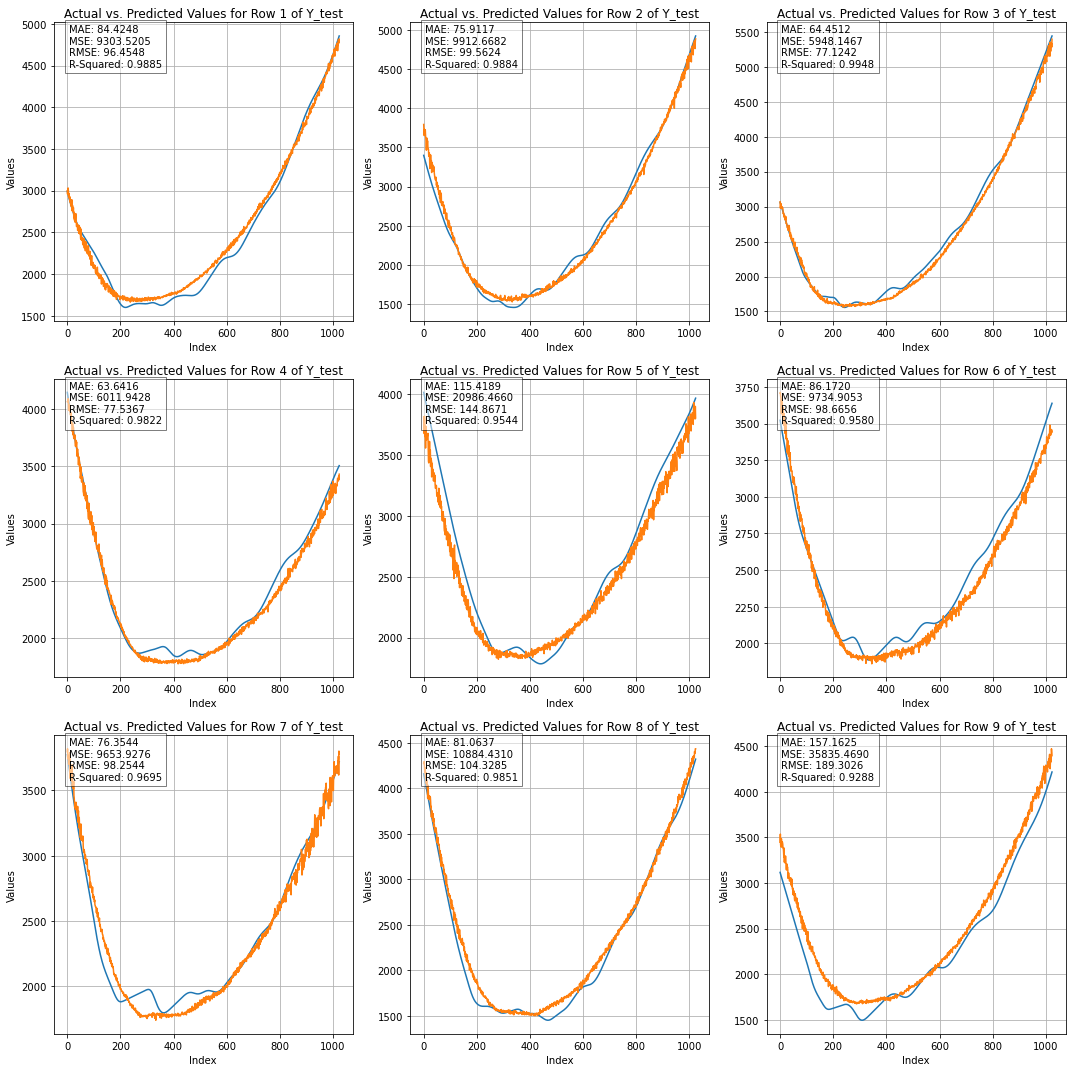

Mean MAE: 89.4001
Mean MSE: 13141.2752
Mean RMSE: 109.5662
Mean R-Squared: 0.9722


In [35]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

mae_list = []
mse_list = []
rmse_list = []
r_squared_list = []

for i, ax in enumerate(axs.flatten()):
    ax.plot(dat.iloc[90+i:91+i, 13:].values.flatten(), label='Actual Values (Y_test)')
    ax.plot(DNN_predictions[i].flatten(), label='Predicted Values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title(f'Actual vs. Predicted Values for Row {i+1} of Y_test')
    ax.grid(True)

    Y_test_i = dat.iloc[90+i:91+i, 13:].values.flatten()
    DNN_predictions_i = DNN_predictions[i].flatten()
    mae = mean_absolute_error(Y_test_i, DNN_predictions_i)
    mse = mean_squared_error(Y_test_i, DNN_predictions_i)
    rmse = np.sqrt(mse)
    r_squared = r2_score(Y_test_i, DNN_predictions_i)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r_squared_list.append(r_squared)

    ax.annotate(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR-Squared: {r_squared:.4f}',
                xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)
mean_r_squared = np.mean(r_squared_list)

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R-Squared: {mean_r_squared:.4f}")

XGB Plot and error for all 9 sets of predictions

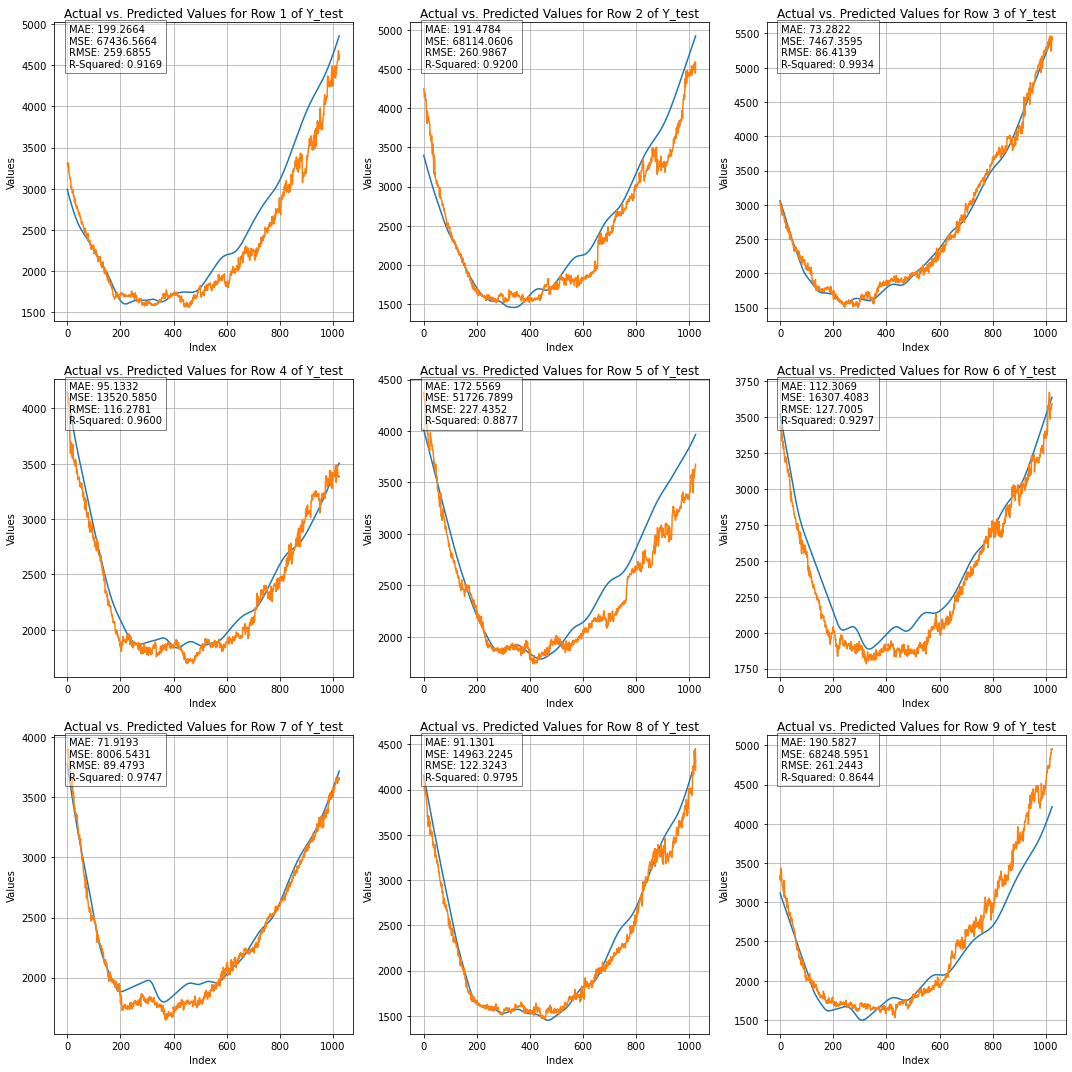

Mean MAE: 133.0729
Mean MSE: 35087.9036
Mean RMSE: 172.3942
Mean R-Squared: 0.9362


In [36]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

mae_list = []
mse_list = []
rmse_list = []
r_squared_list = []

for i, ax in enumerate(axs.flatten()):
    ax.plot(dat.iloc[90+i:91+i, 13:].values.flatten(), label='Actual Values (Y_test)')
    ax.plot(XGB_predictions[i].flatten(), label='Predicted Values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title(f'Actual vs. Predicted Values for Row {i+1} of Y_test')
    ax.grid(True)

    Y_test_i = dat.iloc[90+i:91+i, 13:].values.flatten()
    XGB_predictions_i = XGB_predictions[i].flatten()
    mae = mean_absolute_error(Y_test_i, XGB_predictions_i)
    mse = mean_squared_error(Y_test_i, XGB_predictions_i)
    rmse = np.sqrt(mse)
    r_squared = r2_score(Y_test_i, XGB_predictions_i)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r_squared_list.append(r_squared)

    ax.annotate(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR-Squared: {r_squared:.4f}',
                xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)
mean_r_squared = np.mean(r_squared_list)

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R-Squared: {mean_r_squared:.4f}")

RF Plot and error for all 9 sets of predictions

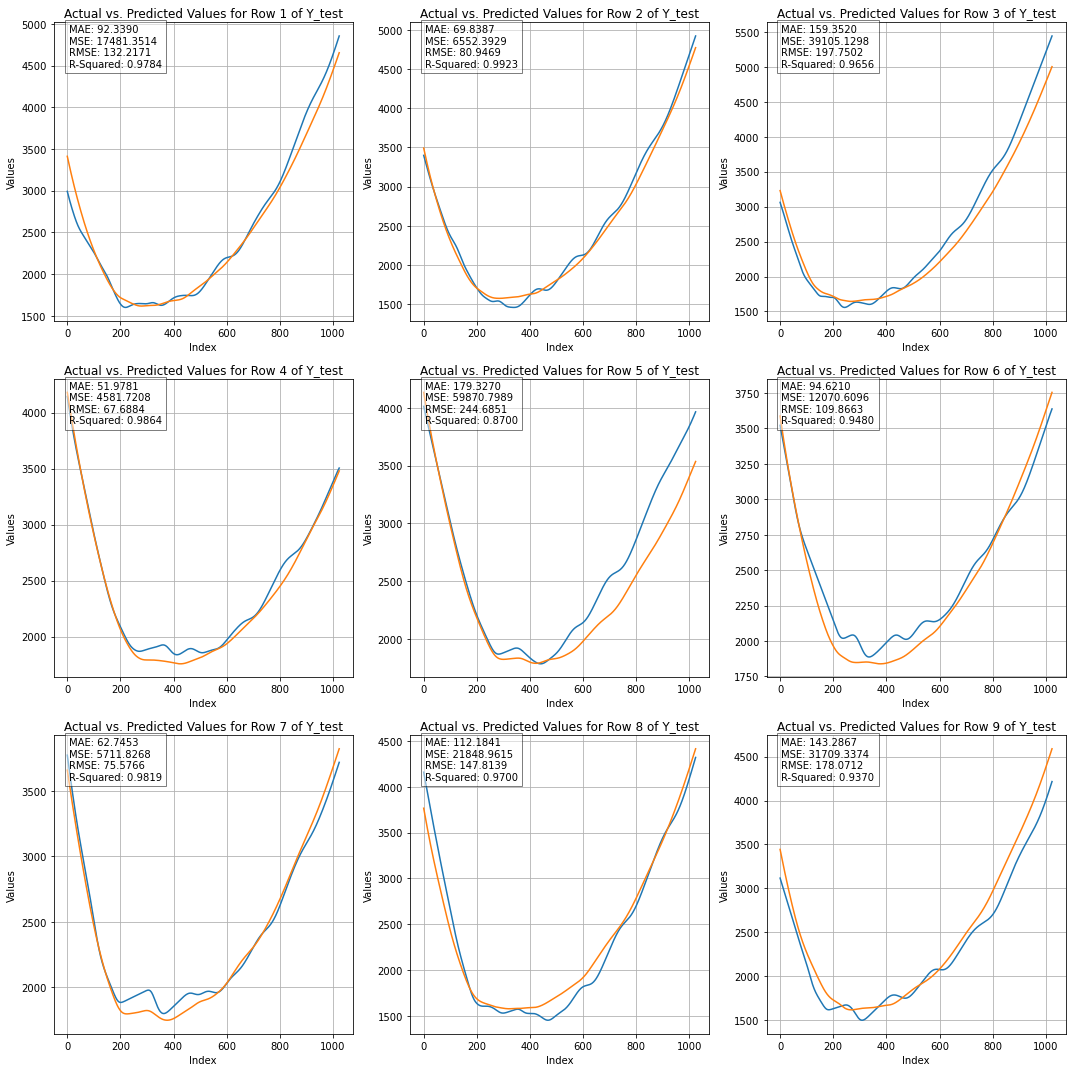

Mean MAE: 107.2969
Mean MSE: 22103.5699
Mean RMSE: 137.1795
Mean R-Squared: 0.9589


In [52]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

mae_list = []
mse_list = []
rmse_list = []
r_squared_list = []

for i, ax in enumerate(axs.flatten()):
    ax.plot(dat.iloc[90+i:91+i, 13:].values.flatten(), label='Actual Values (Y_test)')
    ax.plot(RF_predictions[i].flatten(), label='Predicted Values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title(f'Actual vs. Predicted Values for Row {i+1} of Y_test')
    ax.grid(True)

    Y_test_i = dat.iloc[90+i:91+i, 13:].values.flatten()
    RF_predictions_i = RF_predictions[i].flatten()
    mae = mean_absolute_error(Y_test_i, RF_predictions_i)
    mse = mean_squared_error(Y_test_i, RF_predictions_i)
    rmse = np.sqrt(mse)
    r_squared = r2_score(Y_test_i, RF_predictions_i)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r_squared_list.append(r_squared)

    ax.annotate(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR-Squared: {r_squared:.4f}',
                xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)
mean_r_squared = np.mean(r_squared_list)

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R-Squared: {mean_r_squared:.4f}")

DNN and RF Ensemble

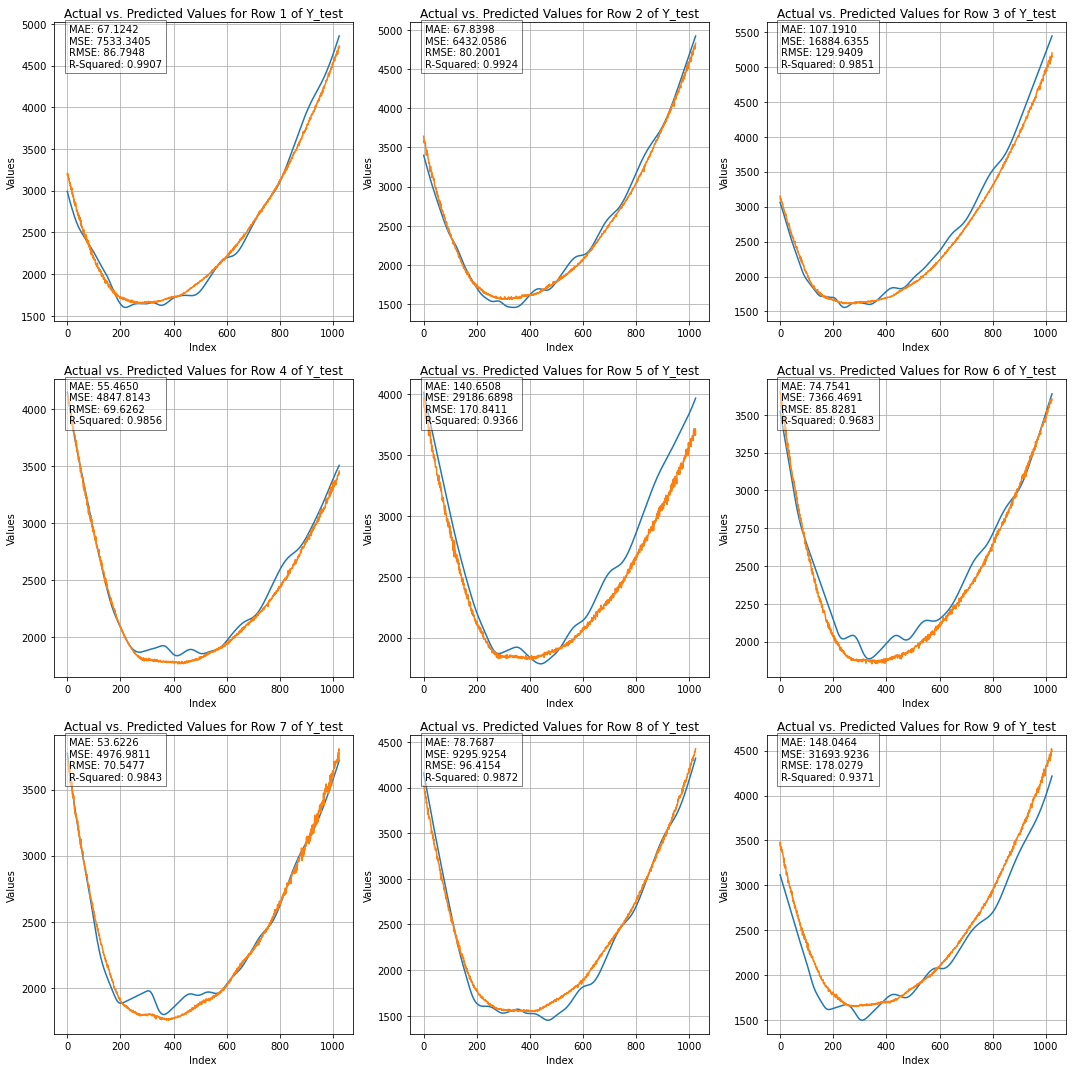

Mean MAE: 88.1625
Mean MSE: 13135.3153
Mean RMSE: 107.5803
Mean R-Squared: 0.9742


In [53]:
DNN_RF_predictions = [(DNN_pred + RF_pred) / 2 for DNN_pred, RF_pred in zip(DNN_predictions, RF_predictions)]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

mae_list = []
mse_list = []
rmse_list = []
r_squared_list = []

for i, ax in enumerate(axs.flatten()):
    ax.plot(dat.iloc[90+i:91+i, 13:].values.flatten(), label='Actual Values (Y_test)')
    ax.plot(DNN_RF_predictions[i].flatten(), label='Predicted Values (DNN_RF)')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title(f'Actual vs. Predicted Values for Row {i+1} of Y_test')
    ax.grid(True)

    Y_test_i = dat.iloc[90+i:91+i, 13:].values.flatten()
    DNN_RF_predictions_i = DNN_RF_predictions[i].flatten()
    mae = mean_absolute_error(Y_test_i, DNN_RF_predictions_i)
    mse = mean_squared_error(Y_test_i, DNN_RF_predictions_i)
    rmse = np.sqrt(mse)
    r_squared = r2_score(Y_test_i, DNN_RF_predictions_i)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r_squared_list.append(r_squared)

    ax.annotate(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR-Squared: {r_squared:.4f}',
                xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)
mean_r_squared = np.mean(r_squared_list)

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R-Squared: {mean_r_squared:.4f}")

Ordered Best to Worst (DNN-RF Ensemble best, DNN Second, RF Third, XGB Last)

#DNN & RF Ensemble

Mean MAE: 88.1625

Mean MSE: 13135.3153

Mean RMSE: 107.5803

Mean R-Squared: 0.9742


#DNN 

Mean MAE: 89.4001

Mean MSE: 13141.2752

Mean RMSE: 109.5662

Mean R-Squared: 0.9722
    


#RF


Mean MAE: 107.2969

Mean MSE: 22103.5699

Mean RMSE: 137.1795

Mean R-Squared: 0.9589



#XGB

Mean MAE: 133.0729

Mean MSE: 35087.9036

Mean RMSE: 172.3942

Mean R-Squared: 0.9362
